# IDS Assignment 5 – Computer Vision

To work in this Colab notebook, first save a copy of it via "File" -> "Save a copy in Drive" in the top-left menu bar.


### 1. Install all missing packages that we need an download our custom FashionMNIST data

The data files will be available locally in your Colab runtime. You can find them through the files menu on the left.

In [2]:
# Install packages
!pip install torchmetrics gdown

# Download training, validation, and test splits
!gdown https://drive.google.com/uc?id=1zYfBlExr_LK-Ld8rmxCTqRU5RAOUVVfh
!gdown https://drive.google.com/uc?id=1PJa_I3qG0P5whuARV_Se1_YUvHzR469R
!gdown https://drive.google.com/uc?id=1pC8-ummMGy1dPhHGPuNsms5_I7HpWgv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

### 2. Import classes and functions we will be using

In [3]:
import math
import os
import random
from typing import Any, Callable, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.optim.lr_scheduler import LinearLR
from torch.utils.data import DataLoader
from torchvision.datasets import VisionDataset
from torchvision.transforms import Compose, Lambda, ToTensor
from torchvision.models.resnet import ResNet, BasicBlock
from torchmetrics.functional.classification import multiclass_confusion_matrix

### 3. Check which PyTorch version we are running and confirm that we are in a GPU runtime.
If this output shows that you are not in a GPU runtime, go to "Runtime" in the top-left menu bar -> "Change runtime type" -> set "Hardware Accelerator: GPU".

In [4]:
print(f"Running PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
!nvidia-smi

Running PyTorch version: 2.2.1+cu121
CUDA available: True
Tue Apr  9 10:39:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+---------

### 4. Make things (more) reproducible by setting random seeds

See here for details: https://pytorch.org/docs/stable/notes/randomness.html

In [5]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### 5. Define our custom IDS FashionMNIST PyTorch dataset

Our model inherits, i.e. is a specific kind of, `VisionDataset` in torchvision.\
This means it has all features defined in `VisionDataset`, unless they are explicitly overridden here, \
plus any additional functionality that may be defined below. You can read more about `VisionDataset` here: https://pytorch.org/vision/main/generated/torchvision.datasets.VisionDataset.html.

In [6]:
class IDSFashionMnistDataset(VisionDataset):
    """
    FashionMNIST dataset for the IDS course which loads custom data files from disk
    """

    classes = [
        "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
    ]

    def __init__(
        self,
        root: str,
        split: str = "training",
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)

        if not split in ["training", "validation", "test"]:
            raise ValueError("Split should be 'training', 'validation', or 'test'.")

        self.split = split
        self.root = root

        self.data, self.targets = self._load_data()

    def _load_data(self):
        data = torch.load(os.path.join(self.root, f"fashion_mnist_{self.split}.pt"))
        images = data[:, :-1].reshape(-1, 28, 28)  # 28x28 resolution
        labels = data[:, -1]
        return images, labels

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode="L")

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)

### 6. Define our custom ResNet-18 model for FashionMNIST
The original ResNet-18 uses 3-channel (RGB) inputs and has 1000 output classes based on ImageNet-1K.

https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

We instead use single-channel inputs (Grayscale) and 10 output classes according to FashionMNIST.

In [7]:
class FashionMnistResNet18(ResNet):
    """
    Custom ResNet-18 model which uses 1 input channel (grayscale) and has 10 output classes
    """
    def __init__(self):
        super().__init__(BasicBlock, [2,2,2,2,2], num_classes=10)
        self.conv1 = nn.Conv2d(1, 64,
          kernel_size=(7, 7),
          stride=(2, 2),
          padding=(3, 3),
          bias=False
        )

### 7. Load our custom FashionMNIST data

Here, we load our data using the `IDSFashionMnistDataset` class defined above. We also make use of the functionality in torchvision's `VisionDataset`, which `IDSFashionMnistDataset` inherits from, to set the transformations we want to apply when retrieving examples from our dataset. We use the `transform` keyword argument for this and compose our transformations using torchvision's `Compose` (https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html). In our base setting, the only transformation we apply is `ToTensor`, which converts our `PIL.Image` inputs into PyTorch tensors.

In [8]:
# Create base transformation for our dataset
# TODO: how can these be modified to randomly flip examples?
base_transform = Compose([
    ToTensor(),
])

# Load datasets
train_dataset = IDSFashionMnistDataset(".", "training", transform=base_transform)
validation_dataset = IDSFashionMnistDataset(".", "validation", transform=base_transform)
test_dataset = IDSFashionMnistDataset(".", "test", transform=base_transform)

# Check the sizes of our datasets
print(f"Training dataset length = {len(train_dataset)}")
print(f"Validation dataset length = {len(validation_dataset)}")
print(f"Test dataset length = {len(test_dataset)}")

Training dataset length = 5000
Validation dataset length = 1000
Test dataset length = 1000


### 8. Implement our evaluation function and training loop

Below, we provide some rudimentary functionality for training and evaluation,\
as well as metric storing and logging, for our experiments.

In [9]:
def log_metrics(metrics: dict, step: Optional[int] = None):
    """
    Log metrics stored in a dictionary
    """

    # During training, it can be useful to also log the current step
    if step is not None:
        print(f"\nMetrics step {step}:")

    for k, v in metrics.items():
        # We ignore the confusion matrix when logging metrics
        if not k.endswith("conf_matrix"):
            print(f"  {k}: {v}")

def evaluate(model, eval_dataloader, prefix="eval"):
    """
    Evaluation function that computes the loss, accuracy, and confusion matrix for the dataset
    passed via the `eval_dataloader` argument
    """

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Move model to GPU
    model.cuda()

    # Set model to evaluation mode (e.g. to disable dropout)
    model.eval()

    eval_loss = 0
    y_pred = None
    y_true = None
    num_classes = None

    for batch_idx, batch in enumerate(tqdm(eval_dataloader, desc=f"Evaluating")):
        # Loop over batches in dataloader

        # Move batch to GPU
        inputs, labels = batch
        inputs = inputs.cuda()
        labels = labels.cuda()

        # Use no_grad mode to disable gradient computation
        with torch.no_grad():
            # Get model outputs
            outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        eval_loss += loss.detach().cpu().item()

        if num_classes is None:
            num_classes = len(outputs[0])

        # Get class predictions
        preds = torch.argmax(outputs, dim=-1)

        # Accumulate predictions and true classes over batches
        y_pred = torch.cat([y_pred, preds]) if y_pred is not None else preds
        y_true = torch.cat([y_true, labels]) if y_true is not None else labels


    # Move predictions and true classes back to CPU
    y_pred = y_pred.detach().cpu()
    y_true = y_true.detach().cpu()

    # Compute metrics
    eval_loss /= len(eval_dataloader)
    eval_acc = (y_pred == y_true).sum() / len(y_true)
    eval_conf_matrix = multiclass_confusion_matrix(
        y_pred, y_true, num_classes=num_classes
    )

    # Store metrics in a dictionary
    metrics = {
        f"{prefix}_loss": eval_loss,
        f"{prefix}_accuracy": eval_acc.item(),
        f"{prefix}_conf_matrix": eval_conf_matrix.numpy()
    }

    return metrics


def save_best_model(model: nn.Module):
  """
  Simple function that saves the weights of the specified model to disk.
  We use this to keep track of the best model (based on validation loss).
  """
  output_path = "best_model.pt"
  torch.save(model.state_dict(), output_path)
  print(f"Saved new best model to {output_path}\n")


def load_best_model(model: nn.Module, model_path: str = "best_model.pt"):
  """
  Simple function that loads model weights stored at `model_path` into the
  passed model of type `nn.Module`. We use this to load our best model checkpoint.
  """
  model.load_state_dict(torch.load(model_path))
  model.eval()
  print(f"Loaded best {model.__class__.__name__} model from {model_path}\n")
  return model


def train(
  model: nn.Module,
  train_dataloader: DataLoader,
  eval_dataloader: DataLoader,
  num_epochs: int = 20,
  lr: float = 0.1,
  eval_steps: int = 100
):
    """
    Training loop
    """

    # Create SGD optimizer with specified learning rate and fixed momentum
    optimizer = SGD(model.parameters(), lr=lr, momentum=0.9)

    # Create linear learning rate decay schedule
    scheduler = LinearLR(
        optimizer,
        start_factor=1.0,
        end_factor=1e-6,
        total_iters=len(train_dataloader) * num_epochs
    )

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Move model to GPU
    model.cuda()

    total_loss = 0
    total_eval_loss = 0
    global_step = 0
    global_eval_step = 0
    best_eval_loss = float("inf")

    # Store our initial model
    save_best_model(model)

    # Create dictionary to store metrics throughout training
    metrics_dict = {}

    print("Starting model training")

    for epoch_idx in range(num_epochs):
        # Epoch loop (one epoch is one pass over the full training dataset)

        for batch_idx, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch_idx+1}")):
            # Loop over batches in training dataset

            # Set model to training mode
            model.train()

            global_step += 1

            # Move batch to GPU
            inputs, labels = batch
            inputs = inputs.cuda()
            labels = labels.cuda()

            # Get model outputs
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            total_loss += loss.detach().cpu().item()

            # Evaluation loop
            if global_step % eval_steps == 0:
                global_eval_step += 1
                metrics = {
                    "mean_train_loss": total_loss / global_step,
                    "learning_rate": scheduler.get_last_lr()[0]
                }

                # Evaluate on validation and training datasets
                metrics.update(evaluate(model, eval_dataloader, prefix="eval"))
                metrics.update(evaluate(model, train_dataloader, prefix="train"))

                # Update and log metrics
                total_eval_loss += metrics["eval_loss"]
                metrics["mean_eval_loss"] = total_eval_loss / global_eval_step
                log_metrics(metrics, step=global_step)
                metrics_dict[global_step] = metrics

                # Check if our validation loss has decreased, and if so,
                # update our best model checkpoint
                if metrics["eval_loss"] <= best_eval_loss:
                  best_eval_loss = metrics["eval_loss"]
                  save_best_model(model)

            # Compute gradients
            loss.backward()

            # Perform update step
            optimizer.step()

            # Reduce learning rate for stability
            scheduler.step()

            # Set gradients to zero
            model.zero_grad()

    return metrics_dict

### 9. Define hyperparameters, create dataloaders, instantiate model, and run training/evaluation procedure

Here, we set our hyper-parameters for the dataloader (batch size) and the training loop \
(number of epochs, learning rate, and evaluation interval in steps).

We only use very basic data loading functionality. More information on available features can be found here https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader.

In [10]:
# TODO: set your hyperparameters
bs = 256
num_epochs = 100
lr = 0.1
eval_steps = 100

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=bs, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

# Instantiate a new model
model = FashionMnistResNet18()

# Train model and save training and evaluation metrics
metrics_dict = train(
    model, train_dataloader, validation_dataloader, num_epochs=num_epochs, lr=lr, eval_steps=eval_steps
)

Saved new best model to best_model.pt

Starting model training


Evaluating: 100%|██████████| 4/4 [00:00<00:00,  9.78it/s]

Evaluating: 100%|██████████| 20/20 [00:01<00:00, 11.89it/s]



Metrics step 100:
  mean_train_loss: 0.8851224645972252
  learning_rate: 0.09505000494999999
  eval_loss: 0.5271830186247826
  eval_accuracy: 0.7979999780654907
  train_loss: 0.48145744055509565
  train_accuracy: 0.8163999915122986
  mean_eval_loss: 0.5271830186247826


Epoch 5: 100%|██████████| 20/20 [00:04<00:00,  4.61it/s]


Saved new best model to best_model.pt



Evaluating: 100%|██████████| 4/4 [00:00<00:00, 28.77it/s]

Epoch 10: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]



Metrics step 200:
  mean_train_loss: 0.6282526408880948
  learning_rate: 0.09005000994999993
  eval_loss: 0.45154477655887604
  eval_accuracy: 0.8389999866485596
  train_loss: 0.2943940028548241
  train_accuracy: 0.8870000243186951
  mean_eval_loss: 0.4893638975918293
Saved new best model to best_model.pt



Evaluating: 100%|██████████| 4/4 [00:00<00:00, 28.61it/s]

Epoch 15: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]



Metrics step 300:
  mean_train_loss: 0.49692006193101407
  learning_rate: 0.08505001494999989
  eval_loss: 0.44886162132024765
  eval_accuracy: 0.859000027179718
  train_loss: 0.1840268589556217
  train_accuracy: 0.9279999732971191
  mean_eval_loss: 0.47586313883463544
Saved new best model to best_model.pt



Evaluating: 100%|██████████| 4/4 [00:00<00:00, 28.59it/s]

Epoch 20: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]



Metrics step 400:
  mean_train_loss: 0.4080180250480771
  learning_rate: 0.08005001994999977
  eval_loss: 0.6423846185207367
  eval_accuracy: 0.8450000286102295
  train_loss: 0.1410095937550068
  train_accuracy: 0.9491999745368958
  mean_eval_loss: 0.5174935087561607


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 27.54it/s]

Epoch 25: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]



Metrics step 500:
  mean_train_loss: 0.34132088646292685
  learning_rate: 0.07505002494999956
  eval_loss: 0.6593412905931473
  eval_accuracy: 0.8399999737739563
  train_loss: 0.04789180113002658
  train_accuracy: 0.9851999878883362
  mean_eval_loss: 0.5458630651235581


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 29.90it/s]

Epoch 30: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]



Metrics step 600:
  mean_train_loss: 0.2919566860779499
  learning_rate: 0.07005002994999944
  eval_loss: 1.0717783123254776
  eval_accuracy: 0.8389999866485596
  train_loss: 0.18756111189723015
  train_accuracy: 0.9434000253677368
  mean_eval_loss: 0.6335156063238779


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 21.36it/s]

Epoch 35: 100%|██████████| 20/20 [00:02<00:00,  7.98it/s]



Metrics step 700:
  mean_train_loss: 0.2541433778332014
  learning_rate: 0.06505003494999935
  eval_loss: 1.0487065464258194
  eval_accuracy: 0.8410000205039978
  train_loss: 0.07342242281883955
  train_accuracy: 0.9746000170707703
  mean_eval_loss: 0.6928285977670124


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 27.18it/s]

Epoch 40: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]



Metrics step 800:
  mean_train_loss: 0.22475736911466812
  learning_rate: 0.06005003994999934
  eval_loss: 0.9697324931621552
  eval_accuracy: 0.8389999866485596
  train_loss: 0.0060518333222717045
  train_accuracy: 0.998199999332428
  mean_eval_loss: 0.7274415846914053


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 27.11it/s]

Epoch 45: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]



Metrics step 900:
  mean_train_loss: 0.2011575202055327
  learning_rate: 0.055050044949999356
  eval_loss: 1.0336773991584778
  eval_accuracy: 0.8339999914169312
  train_loss: 0.04887063540518284
  train_accuracy: 0.9825999736785889
  mean_eval_loss: 0.7614677862988578


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 21.20it/s]

Epoch 50: 100%|██████████| 20/20 [00:02<00:00,  7.63it/s]



Metrics step 1000:
  mean_train_loss: 0.18133732114807935
  learning_rate: 0.050050049949999446
  eval_loss: 0.9417082667350769
  eval_accuracy: 0.8669999837875366
  train_loss: 0.00025009419332491236
  train_accuracy: 1.0
  mean_eval_loss: 0.7794918343424797


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 27.84it/s]

Epoch 55: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]



Metrics step 1100:
  mean_train_loss: 0.1648809045243979
  learning_rate: 0.045050054949999536
  eval_loss: 0.9578895568847656
  eval_accuracy: 0.8629999756813049
  train_loss: 0.0001328499954979634
  train_accuracy: 1.0
  mean_eval_loss: 0.7957098091190512


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 28.72it/s]

Epoch 60: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]



Metrics step 1200:
  mean_train_loss: 0.15119777886880303
  learning_rate: 0.04005005994999966
  eval_loss: 0.9871836006641388
  eval_accuracy: 0.8650000095367432
  train_loss: 0.00018158824677811937
  train_accuracy: 1.0
  mean_eval_loss: 0.8116659584144751


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 22.26it/s]

Epoch 65: 100%|██████████| 20/20 [00:02<00:00,  7.47it/s]



Metrics step 1300:
  mean_train_loss: 0.13958577941570324
  learning_rate: 0.03505006494999977
  eval_loss: 0.9643889218568802
  eval_accuracy: 0.8619999885559082
  train_loss: 9.78956815743004e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.8234138786792755


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 25.39it/s]

Epoch 70: 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]



Metrics step 1400:
  mean_train_loss: 0.1296272307756278
  learning_rate: 0.030050069949999845
  eval_loss: 0.9727503061294556
  eval_accuracy: 0.8679999709129333
  train_loss: 7.898078401922249e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.8340807663542884


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 27.89it/s]

Epoch 75: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]



Metrics step 1500:
  mean_train_loss: 0.12099538926917983
  learning_rate: 0.025050074949999862
  eval_loss: 0.9813573807477951
  eval_accuracy: 0.8669999837875366
  train_loss: 6.690854261250933e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.8438992073138555


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 27.01it/s]

Epoch 80: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]



Metrics step 1600:
  mean_train_loss: 0.11344055098774788
  learning_rate: 0.02005007994999987
  eval_loss: 0.9907037317752838
  eval_accuracy: 0.8690000176429749
  train_loss: 5.890843149245484e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.8530744900926948


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 29.05it/s]

Epoch 85: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]



Metrics step 1700:
  mean_train_loss: 0.1067740210458257
  learning_rate: 0.015050084949999864
  eval_loss: 0.9942179769277573
  eval_accuracy: 0.8700000047683716
  train_loss: 5.513820124178892e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.861377048141816


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 28.20it/s]

Epoch 90: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]



Metrics step 1800:
  mean_train_loss: 0.10084858632313626
  learning_rate: 0.010050089949999917
  eval_loss: 0.9908266216516495
  eval_accuracy: 0.8679999709129333
  train_loss: 5.292004916555015e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.8685686911145846


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 26.99it/s]

Epoch 95: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]



Metrics step 1900:
  mean_train_loss: 0.09554665148484147
  learning_rate: 0.005050094949999962
  eval_loss: 0.9961750656366348
  eval_accuracy: 0.8709999918937683
  train_loss: 5.165560041859862e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.8752848160894293


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 27.63it/s]

Epoch 100: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Metrics step 2000:
  mean_train_loss: 0.09077492282350431
  learning_rate: 5.009994999999962e-05
  eval_loss: 1.0056583136320114
  eval_accuracy: 0.8629999756813049
  train_loss: 4.9135167500935495e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.8818034909665584


### 10. Load our saved best model checkpoint

We can make use of the `load_best_model` function defined above to quickly load \
the best model checkpoint for further evaluation.

You can find more information on saving and loading model weights at

https://pytorch.org/tutorials/beginner/saving_loading_models.html.

In [11]:
best_model = load_best_model(FashionMnistResNet18())

Loaded best FashionMnistResNet18 model from best_model.pt



### 11. Evaluate your best model and visualize the confusion matrix

TODO: You should implement this yourself using the functions defined above.

In [49]:
# TODO
evaluation = evaluate(best_model, validation_dataloader)
print('\n')
print(evaluation['eval_conf_matrix'])
print('\n')



epochs = sorted(metrics_dict.keys())

epochs_list = []

for epoch in metrics_dict.keys():
  epochs_list.append(epoch)

mean_train_losses = [metrics_dict[epoch]['mean_train_loss'] for epoch in epochs]
mean_eval_losses = [metrics_dict[epoch]['mean_eval_loss'] for epoch in epochs]
print(epochs_list)

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 18.40it/s]



[[ 59   0   2   7   0   0  17   0   1   0]
 [  0 103   1   2   0   0   0   0   0   0]
 [  0   0  93   3  11   0   7   0   0   0]
 [  0   0   0  91   4   0   0   0   0   0]
 [  0   0  13   7  67   0   4   0   0   0]
 [  0   0   0   0   0  91   0   0   0   2]
 [  8   0  15   7   8   0  55   0   0   0]
 [  0   0   0   0   0   5   0  88   0   7]
 [  0   0   0   2   1   1   2   0 105   0]
 [  0   0   0   0   0   1   0   3   0 107]]


[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]


### 12. Plot your loss curves

TODO: You should implement this yourself. Use the `metrics_dict` returned by the training loop.

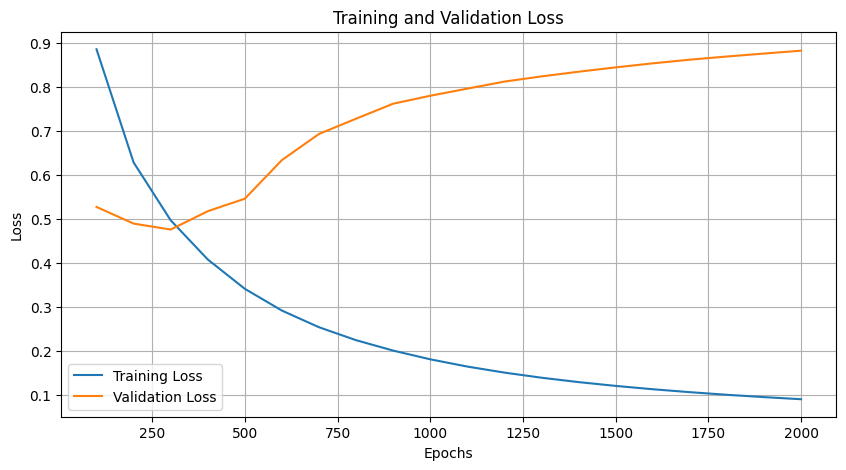

In [50]:
# TODO

plt.figure(figsize=(10, 5))

plt.plot(epochs_list, mean_train_losses, label='Training Loss')
plt.plot(epochs_list, mean_eval_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



### 12. Plot your accuracy curves

TODO: You should implement this yourself. Use the `metrics_dict` returned by the training loop.

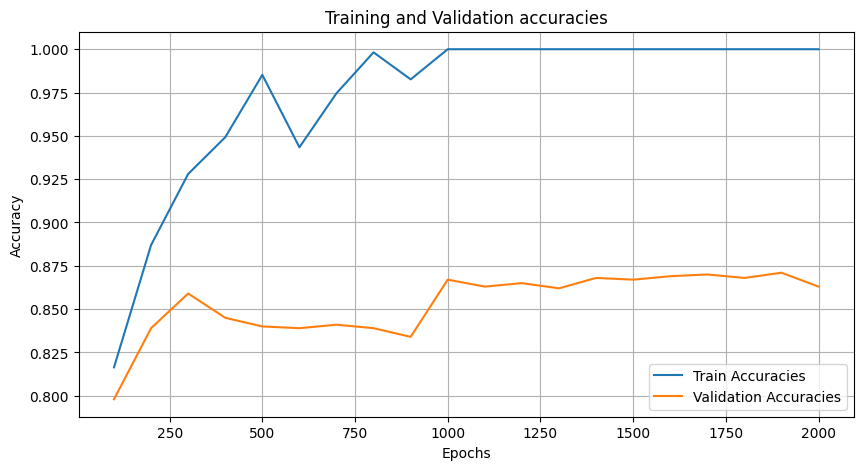

In [54]:
# TODO

train_accuracies = [metrics_dict[epoch]['train_accuracy'] for epoch in epochs]
eval_accuracies = [metrics_dict[epoch]['eval_accuracy'] for epoch in epochs]

plt.figure(figsize=(10, 5))

plt.plot(epochs_list, train_accuracies, label='Train Accuracies')
plt.plot(epochs_list, eval_accuracies, label='Validation Accuracies')
plt.title('Training and Validation accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [58]:

eval_accuracies = [metrics_dict[epoch]['eval_accuracy'] for epoch in epochs]
mean_eval_losses = [metrics_dict[epoch]['mean_eval_loss'] for epoch in epochs]

best_epoch = min(metrics_dict, key=lambda x: metrics_dict[x]['mean_eval_loss'])
best_test_accuracy = metrics_dict[best_epoch]['eval_accuracy']
print(best_test_accuracy)


0.859000027179718
